# UnetAtt Research 1.
## Learning Rate, balance, scale

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import datetime
import pprint


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W, C
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics


from seismicpro.batchflow.batchflow.research import Research, Option, KV
from seismicpro.batchflow.batchflow.utils import plot_results_by_config


%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


Index dataset

In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

TraceNumber offset TRACE_SEQUENCE_FILE  \
                                               raw   
FieldRecord                                          
111906             1656     35                   1   
111906             1657     36                   2   
111906             1655     78                   3   
111906             1658     79                   4   
111906             1654    127                   5   

                                                       file_id  \
                                                           raw   
FieldRecord                                                      
111906       /notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...   
111906       /notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...   
111906       /notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...   
111906       /notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...   
111906       /notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...   

            TRACE_SEQUENCE_FILE  \
                           lift   
FieldRecord                       
111906                        1   
111906                        2   
111906                        3   
111906                        4   
111906                        5   

                                                       file_id  
                                                          lift  
FieldRecord                                                     
111906       /notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...  
111906       /notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...  
111906       /notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...  
111906       /notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...  
111906       /notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...

Reserve 10 field records for model training:

In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [4]:
model_config = {
    'initial_block/inputs': 'trace_raw',
    'inputs': dict(trace_raw={'shape': (3000, 1)},
#                    offset={'shape': (1, )},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'balance': C('balance')}),
    'optimizer': ('Adam', {'learning_rate': C('lr')}),
#     'decay': {'name': 'cyclic', 'learning_rate':0.0001, 'max_lr': 0.003, 'step_size': 20},
#     'decay': {'name': 'invtime', 'learning_rate':0.001, 'decay_steps': 100, 'decay_rate': 0.05},
    'common/data_format': 'channels_last',
    'body': {
        'main': {
            'encoder/num_stages': 5,
            'encoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256],
                                   kernel_size=[7, 5, 5, 5, 5],
#                                    kernel_size=C('kernel_main'),
                                   activation=tf.nn.elu),
            'encoder/downsample': dict(layout='pd',
                                       pool_size=2,
                                       pool_strides=2,
                                       dropout_rate=0.05),

            'decoder/blocks': dict(layout='ca ca',
                                   filters=[16, 32, 64, 128, 256][::-1],
                                   kernel_size=[7, 5, 5, 5, 5][::-1],
#                                    kernel_size=C('kernel_main')[::-1],
                                   activation=tf.nn.elu),
            'decoder/upsample': dict(layout='tad',
                                     kernel_size=[7, 5, 5, 5, 5][::-1],
#                                      kernel_size=C('kernel_main')[::-1],
                                     strides=2,
                                     dropout_rate=0.05,
                                     activation=tf.nn.elu,),
          },
        'attn': {
              'encoder/num_stages': 3,
              'encoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'encoder/downsample': dict(layout='pd',
                                         pool_size=2,
                                         pool_strides=2,
                                         dropout_rate=0.05),

              'decoder/blocks': dict(layout='ca ca',
                                     filters=[8, 16, 32][::-1],
                                     kernel_size=3,
                                     activation=tf.nn.elu),
              'decoder/upsample': dict(layout='ta d',
                                       kernel_size=3,
                                       strides=2,
                                       dropout_rate=0.05,
                                       activation=tf.nn.elu),
        },
    },
    'head': {'scale': C('scale')},
    'train_steps': {
#         'sss': {},
                
        'step_main': {'scope': 'main_branch'},
        'step_attention': {'scope': ['attention_branch', 'attention_dense']},

    }
}

In [5]:
grid = (Option('balance', [0.03, 0.05, 0.07])
        * Option('lr', [0.0001, 0.001, 0.01])
        * Option('scale', [1, 2])
#         * Option('layout', ['ca ca', 'cna cna'])
#        * Option('kernel_main', [KV([7] * 5, '7'), KV([7] + [5]*4, '7 5'), KV([7, 5, 3, 3, 3], '7 5 3')])
       )
list(grid.gen_configs())

[ConfigAlias({'scale': '1', 'balance': '0.03', 'lr': '0.0001'}),
 ConfigAlias({'scale': '2', 'balance': '0.03', 'lr': '0.0001'}),
 ConfigAlias({'scale': '1', 'balance': '0.03', 'lr': '0.001'}),
 ConfigAlias({'scale': '2', 'balance': '0.03', 'lr': '0.001'}),
 ConfigAlias({'scale': '1', 'balance': '0.03', 'lr': '0.01'}),
 ConfigAlias({'scale': '2', 'balance': '0.03', 'lr': '0.01'}),
 ConfigAlias({'scale': '1', 'balance': '0.05', 'lr': '0.0001'}),
 ConfigAlias({'scale': '2', 'balance': '0.05', 'lr': '0.0001'}),
 ConfigAlias({'scale': '1', 'balance': '0.05', 'lr': '0.001'}),
 ConfigAlias({'scale': '2', 'balance': '0.05', 'lr': '0.001'}),
 ConfigAlias({'scale': '1', 'balance': '0.05', 'lr': '0.01'}),
 ConfigAlias({'scale': '2', 'balance': '0.05', 'lr': '0.01'}),
 ConfigAlias({'scale': '1', 'balance': '0.07', 'lr': '0.0001'}),
 ConfigAlias({'scale': '2', 'balance': '0.07', 'lr': '0.0001'}),
 ConfigAlias({'scale': '1', 'balance': '0.07', 'lr': '0.001'}),
 ConfigAlias({'scale': '2', 'balance':

## Training

Define a train pipeline:

In [6]:
BATCH_SIZE=64

def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
#                           'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': exp_stack(batch.lift)}


train_root = (train_set.p
              .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
              .run_later(BATCH_SIZE, shuffle=True, n_epochs=None)
              )

train_template = (Pipeline()
                  .init_model('dynamic', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss')
                  .train_model('unet', make_data=make_data, fetches='loss_step_main', save_to=V('loss'))
                 )

In [7]:
# def save_model(iteration, experiment, pipeline, model_name, path='./', **kwargs):
#     """ Save model to a path."""
    
#     ne_m = ppl.get_model_by_name(model_name)
#     model = eval_expr(ne_m, pipeline=ppl)
    
#     tz = datetime.timezone(datetime.timedelta(hours=3))
#     path = os.path.join(path, model.__name__, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))   
    
#     model.save(path)
#     print(path)
    
#     loss = np.array(ppl.get_variable('loss'))

#     readme = os.path.join(path, 'README.txt')
#     with open(readme, 'w') as inpf:
#         inpf.write("Iteration: {}\n".format(iteration))
#         inpf.write("Model name: {}\n".format(model.__name__))
#         inpf.write("Avg final loss (100 points): {}\n".format(np.mean(loss[-100:])))
#         inpf.write("\nConfig:\n")
#         inpf.write(pprint.pformat(experiment[pipeline].config.config().config, compact=True))
#         inpf.write("\nAdditional Info:\n")
#         inpf.write(pprint.pformat(kwargs))
        
#     return path

def save_model(iteration, experiment, pipeline, model_name, path='./', **kwargs):
    """ Save model to a path."""
    ppl = experiment[pipeline].pipeline

    tz = datetime.timezone(datetime.timedelta(hours=3))
    path = os.path.join(path, str(datetime.datetime.now(tz=tz)).replace(' ', '_'))   
    ppl.save_model_now(model_name, path)
    
    loss = np.array(ppl.get_variable('loss'))
    readme = os.path.join(path, 'README.txt')
    with open(readme, 'w') as inpf:
        inpf.write("Iteration: {}\n".format(iteration))
        inpf.write("Final loss: {}\n".format(loss))
        inpf.write("\nConfig:\n")
        inpf.write(pprint.pformat(experiment[pipeline].config.config().config, compact=True))
        inpf.write("\nAdditional Info:\n")
        inpf.write(pprint.pformat(kwargs))
        
    return path

In [8]:
!rm -r test

In [9]:
!rm -r my_mdl

In [10]:
res_name = 'test'
# add_info = dict(fields=list(fi), n_iters=500, **paths)

research = (Research()
            .add_pipeline(train_root+train_template, variables='loss', name='train_ppl')
            .add_function(save_model, returns='snapshot_path', name='save_model_fn', logging=True,
                          execute='last', pipeline='train_ppl', model_name='unet', path='./my_mdl/noise_dataset_1')
            .add_grid(grid))

research.run(n_reps=3, n_iters=1600, name=res_name, bar=True, gpu=[5])

Research test is starting...


  0%|          | 0/86400 [00:00<?, ?it/s]

Distributor has 54 jobs with 1600 iterations. Totally: 86400


100%|██████████| 86400/86400 [6:57:54<00:00,  3.45it/s]


In [11]:
res = research.load_results(use_alias=True)

In [18]:
res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86454 entries, 0 to 0
Data columns (total 6 columns):
config           86454 non-null object
iteration        86454 non-null int64
loss             62938 non-null float64
name             86454 non-null object
repetition       86454 non-null int64
snapshot_path    54 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 4.6+ MB


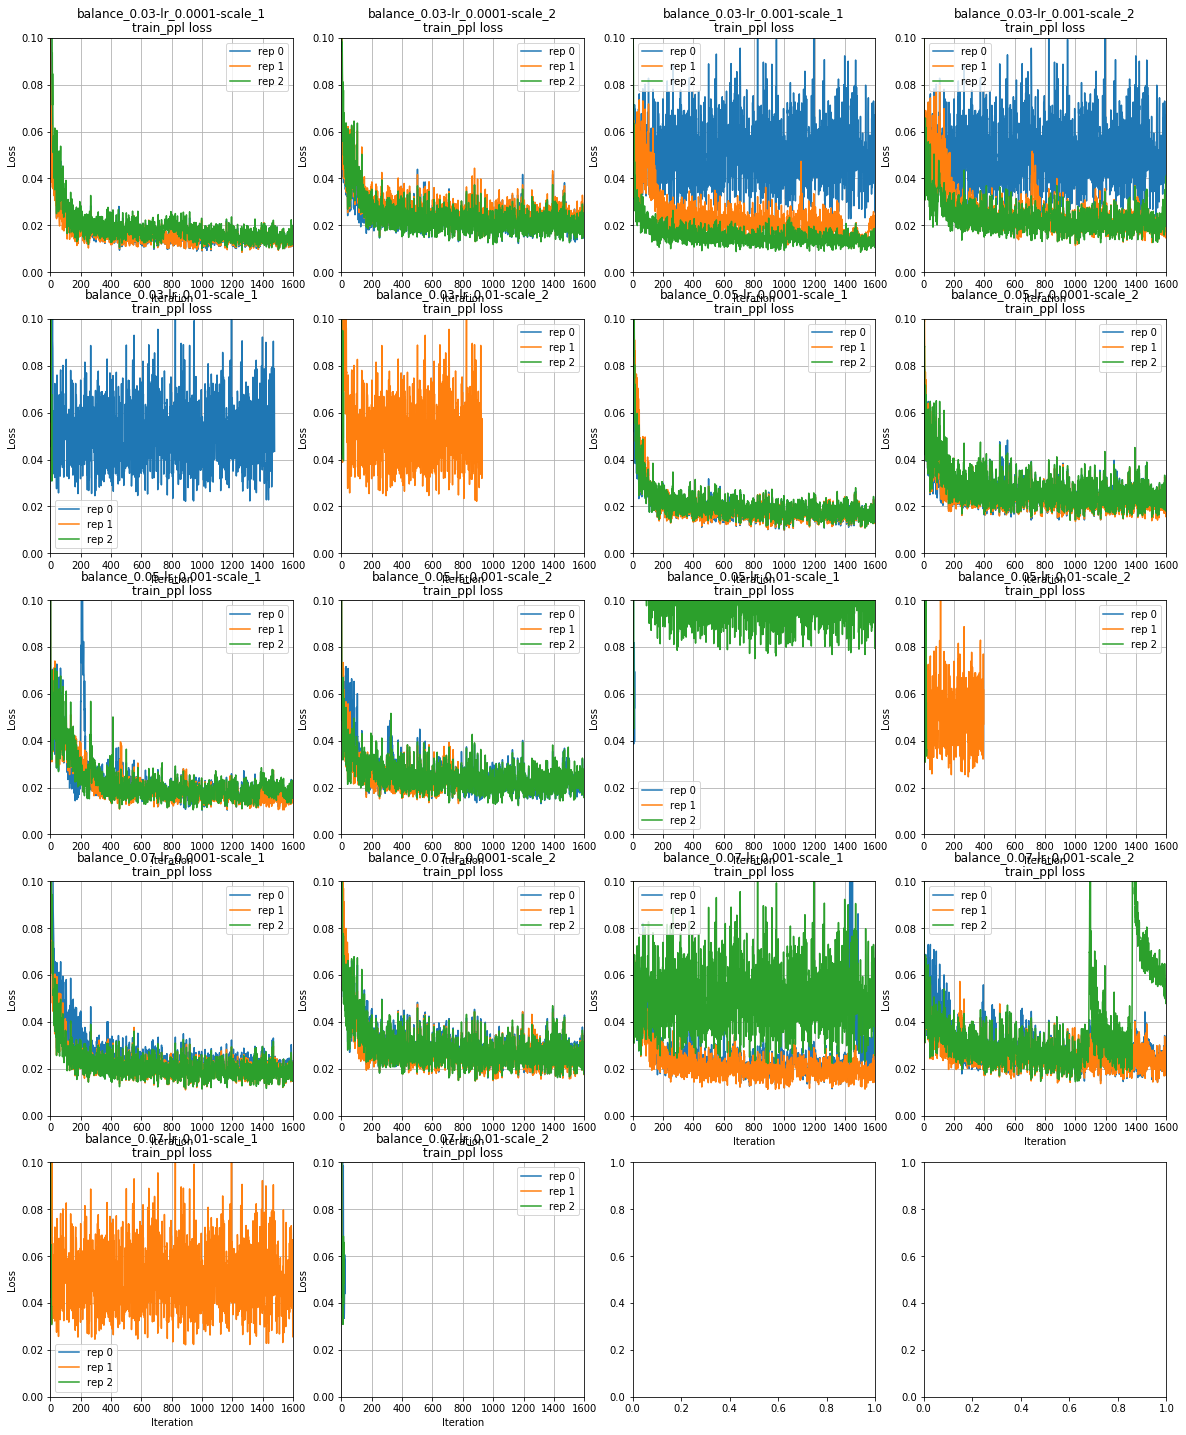

In [13]:
plot_results_by_config(res, {'train_ppl': 'loss'}, layout='square', ylim=(0, 0.1))

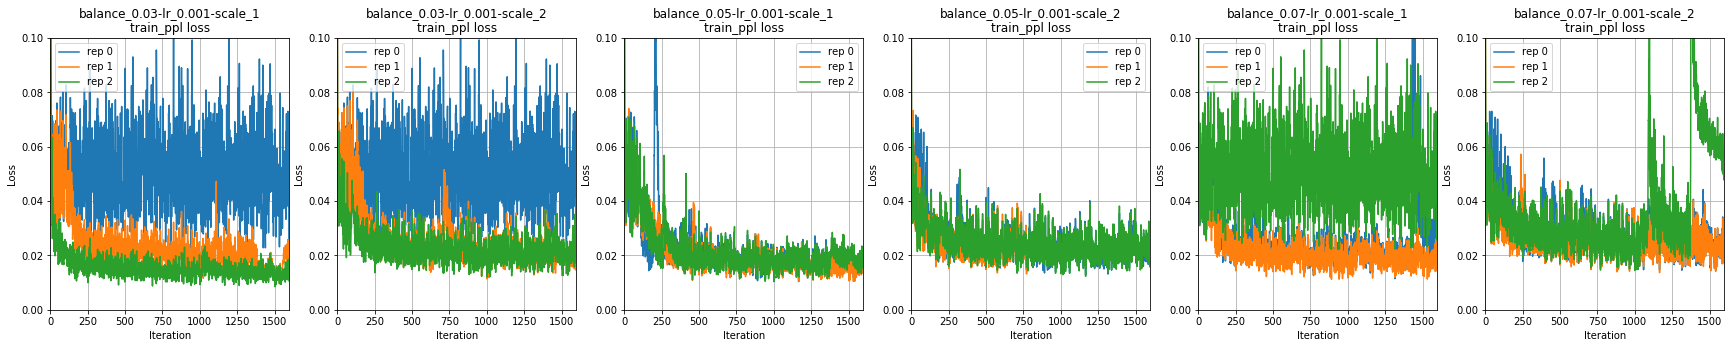

In [16]:
plot_results_by_config(res[res.config.str.contains('lr_0.001')], {'train_ppl': 'loss'}, layout='force_flat', ylim=(0, 0.1))

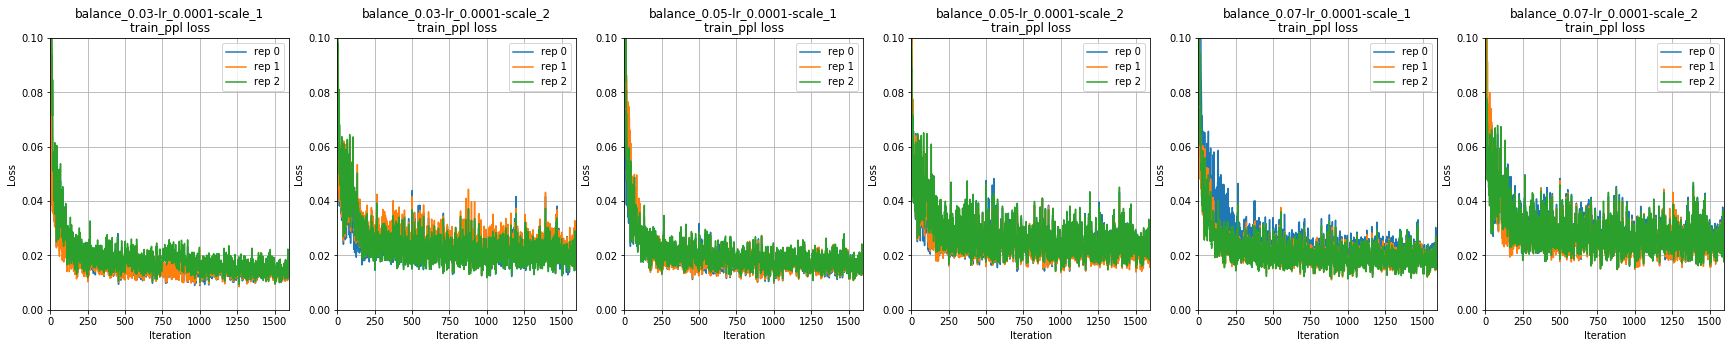

In [17]:
plot_results_by_config(res[res.config.str.contains('lr_0.0001')], {'train_ppl': 'loss'}, layout='force_flat', ylim=(0, 0.1))

In [27]:
snapshots = res[(res.config.str.contains('lr_0.0001')) & (res.name == 'save_model_fn') & (res.repetition == 0)][['config', 'snapshot_path']]
snapshots

config  \
0  balance_0.03-lr_0.0001-scale_1   
0  balance_0.03-lr_0.0001-scale_2   
0  balance_0.05-lr_0.0001-scale_1   
0  balance_0.05-lr_0.0001-scale_2   
0  balance_0.07-lr_0.0001-scale_1   
0  balance_0.07-lr_0.0001-scale_2   

                                       snapshot_path  
0  ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.2...  
0  ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.6...  
0  ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.4...  
0  ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.6...  
0  ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.7...  
0  ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.7...

In [49]:
def check_res(i, index, model_path):  
    test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))
    
    fetches=['out_lift', 'attention_sigmoid', 'out_att'] 

    test_pipeline = (Pipeline()
                 .load_model("dynamic", UnetAtt, 'unet', path=model_path)
                 .init_variable('res', default=list())
                 .init_variable('raw', default=list())
                 .init_variable('lift', default=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))
    
    test_pipeline = test_pipeline << test_set
    test_pipeline = test_pipeline.run(batch_size=2000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)
    
    raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
    lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
    out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
    att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
    att_raw = np.squeeze(np.vstack([x[2] for x in test_pipeline.get_variable('res')]))
   
    return raw, att, att_raw, lift, out


def draw(field_idx, snapshots, arrs_maker, names, cvs, ax):
    plt.suptitle('Field ' + str(field_idx))
    for x, (config, model_path) in enumerate(zip(snapshots.config, snapshots.snapshot_path)):
        raw, att, att_raw, lift, out = check_res(field_idx, index, model_path)

        ax[x, 0].set_ylabel(config)

        for y, arr in enumerate(arrs_maker(raw, att, att_raw, lift, out)):

            arr = np.squeeze(arr)
            xlim = (0, len(arr))
            ylim = (0, len(arr[0]))


            if isinstance(cvs[y], tuple):
                cvmin, cvmax = cvs[y]
            else:
                cvmax = cvs[y]
                cvmin = -cvmax

            ax[x, y].imshow(arr.T, cmap='gray', vmin=cvmin, vmax=cvmax)
            ax[x, y].set_title(names[y])
            ax[x, y].set_ylim([ylim[1], ylim[0]])
            ax[x,y].set_xlim(xlim)
            ax[x, y].set_aspect('auto')



  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




 25%|██▌       | 1/4 [00:04<00:14,  4.82s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




 50%|█████     | 2/4 [00:09<00:09,  4.90s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




 75%|███████▌  | 3/4 [00:15<00:05,  5.10s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




100%|██████████| 4/4 [00:20<00:00,  4.97s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




 25%|██▌       | 1/4 [00:05<00:16,  5.44s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




 50%|█████     | 2/4 [00:10<00:10,  5.41s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




 75%|███████▌  | 3/4 [00:16<00:05,  5.49s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




100%|██████████| 4/4 [00:21<00:00,  5.36s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




 25%|██▌       | 1/4 [00:05<00:17,  5.81s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




 50%|█████     | 2/4 [00:11<00:11,  5.68s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




 75%|███████▌  | 3/4 [00:16<00:05,  5.57s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




100%|██████████| 4/4 [00:21<00:00,  5.37s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




 25%|██▌       | 1/4 [00:05<00:16,  5.39s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




 50%|█████     | 2/4 [00:10<00:10,  5.40s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




 75%|███████▌  | 3/4 [00:16<00:05,  5.43s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




100%|██████████| 4/4 [00:21<00:00,  5.32s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




 25%|██▌       | 1/4 [00:05<00:15,  5.04s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




 50%|█████     | 2/4 [00:10<00:10,  5.07s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




 75%|███████▌  | 3/4 [00:15<00:05,  5.18s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




100%|██████████| 4/4 [00:20<00:00,  5.00s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




 25%|██▌       | 1/4 [00:05<00:16,  5.65s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




 50%|█████     | 2/4 [00:11<00:11,  5.58s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




 75%|███████▌  | 3/4 [00:16<00:05,  5.51s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




100%|██████████| 4/4 [00:21<00:00,  5.35s/it]

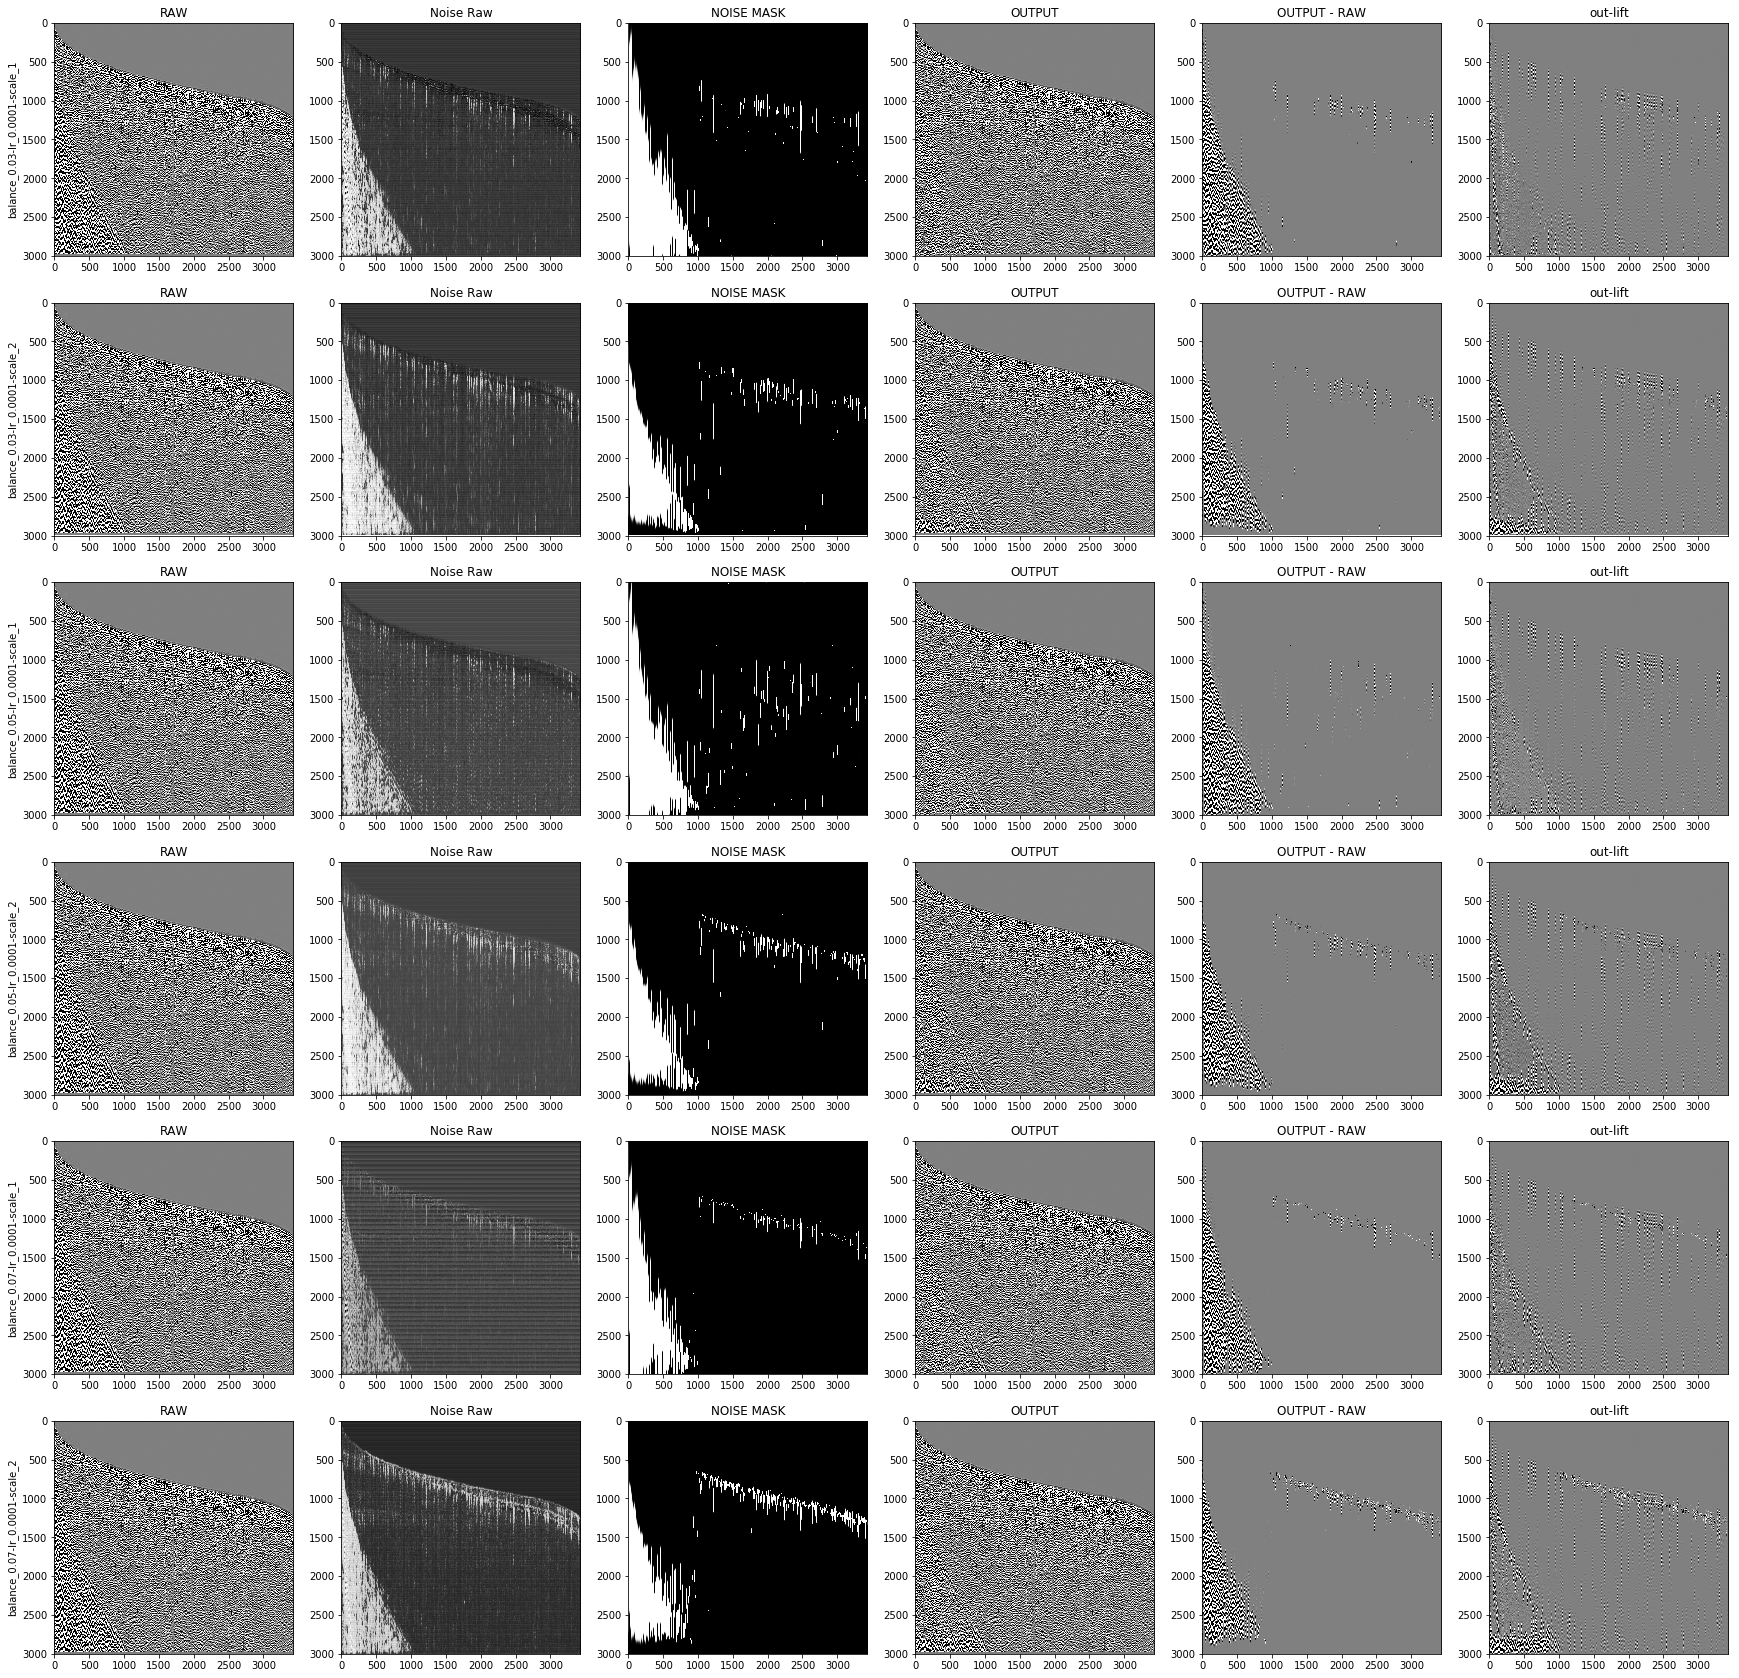

In [42]:
field_idx = 20
fig, ax = plt.subplots(len(snapshots.config), 6, figsize=(30, 30), squeeze=False)
names=['RAW', 'Noise Raw', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW', 'out-lift']
cvs = [0.1, (0, 1), (0, 1), 0.1, 0.1, 0.1]
def arrs_maker(raw, att, att_raw, lift, out):
    return [raw, att_raw, att, out, out - raw, out -lift]

draw(field_idx, snapshots, arrs_maker, names, cvs, ax)



  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.86s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200




100%|██████████| 2/2 [00:15<00:00,  7.41s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.00s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:38:33.635037+03:00/model-3200




100%|██████████| 2/2 [00:11<00:00,  5.99s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.40s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200




100%|██████████| 2/2 [00:12<00:00,  6.37s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.39s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:25:13.677638+03:00/model-3200




100%|██████████| 2/2 [00:12<00:00,  6.18s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.52s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200




100%|██████████| 2/2 [00:12<00:00,  6.33s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




 50%|█████     | 1/2 [00:06<00:06,  6.09s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:11:44.771808+03:00/model-3200




100%|██████████| 2/2 [00:12<00:00,  6.13s/it]

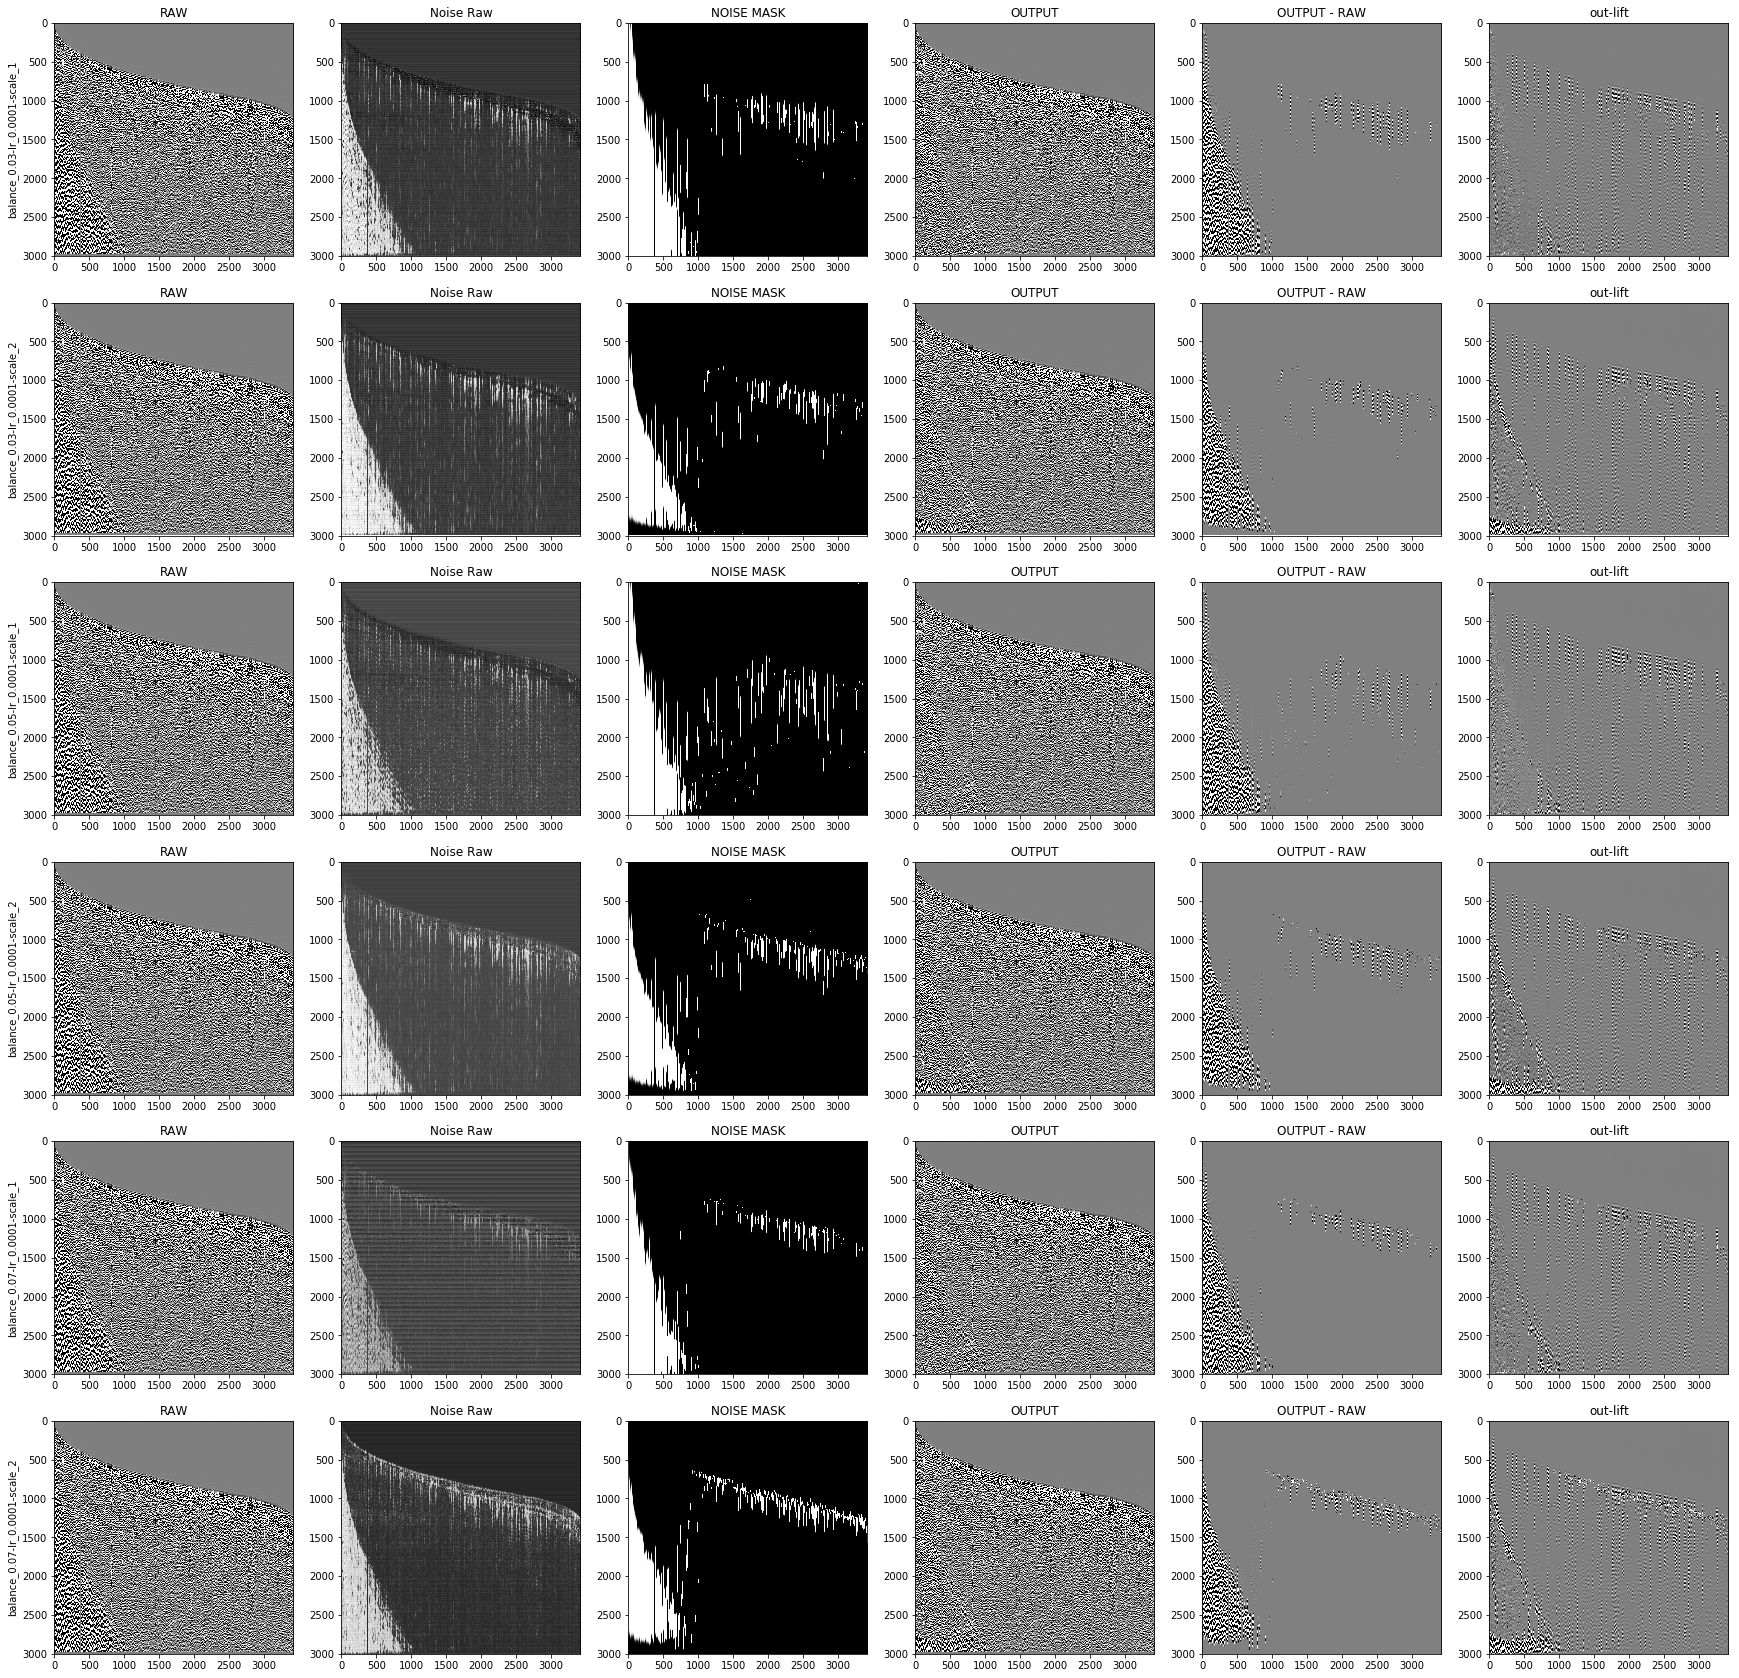

In [48]:
field_idx = 48
fig, ax = plt.subplots(len(snapshots.config), 6, figsize=(30, 30), squeeze=False)

draw(field_idx, snapshots, arrs_maker, names, cvs, ax)




  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200





 50%|█████     | 1/2 [00:06<00:06,  6.57s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200





100%|██████████| 2/2 [00:12<00:00,  6.33s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200





 50%|█████     | 1/2 [00:06<00:06,  6.75s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200





100%|██████████| 2/2 [00:12<00:00,  6.47s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200





 50%|█████     | 1/2 [00:06<00:06,  6.46s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200





100%|██████████| 2/2 [00:12<00:00,  6.33s/it]

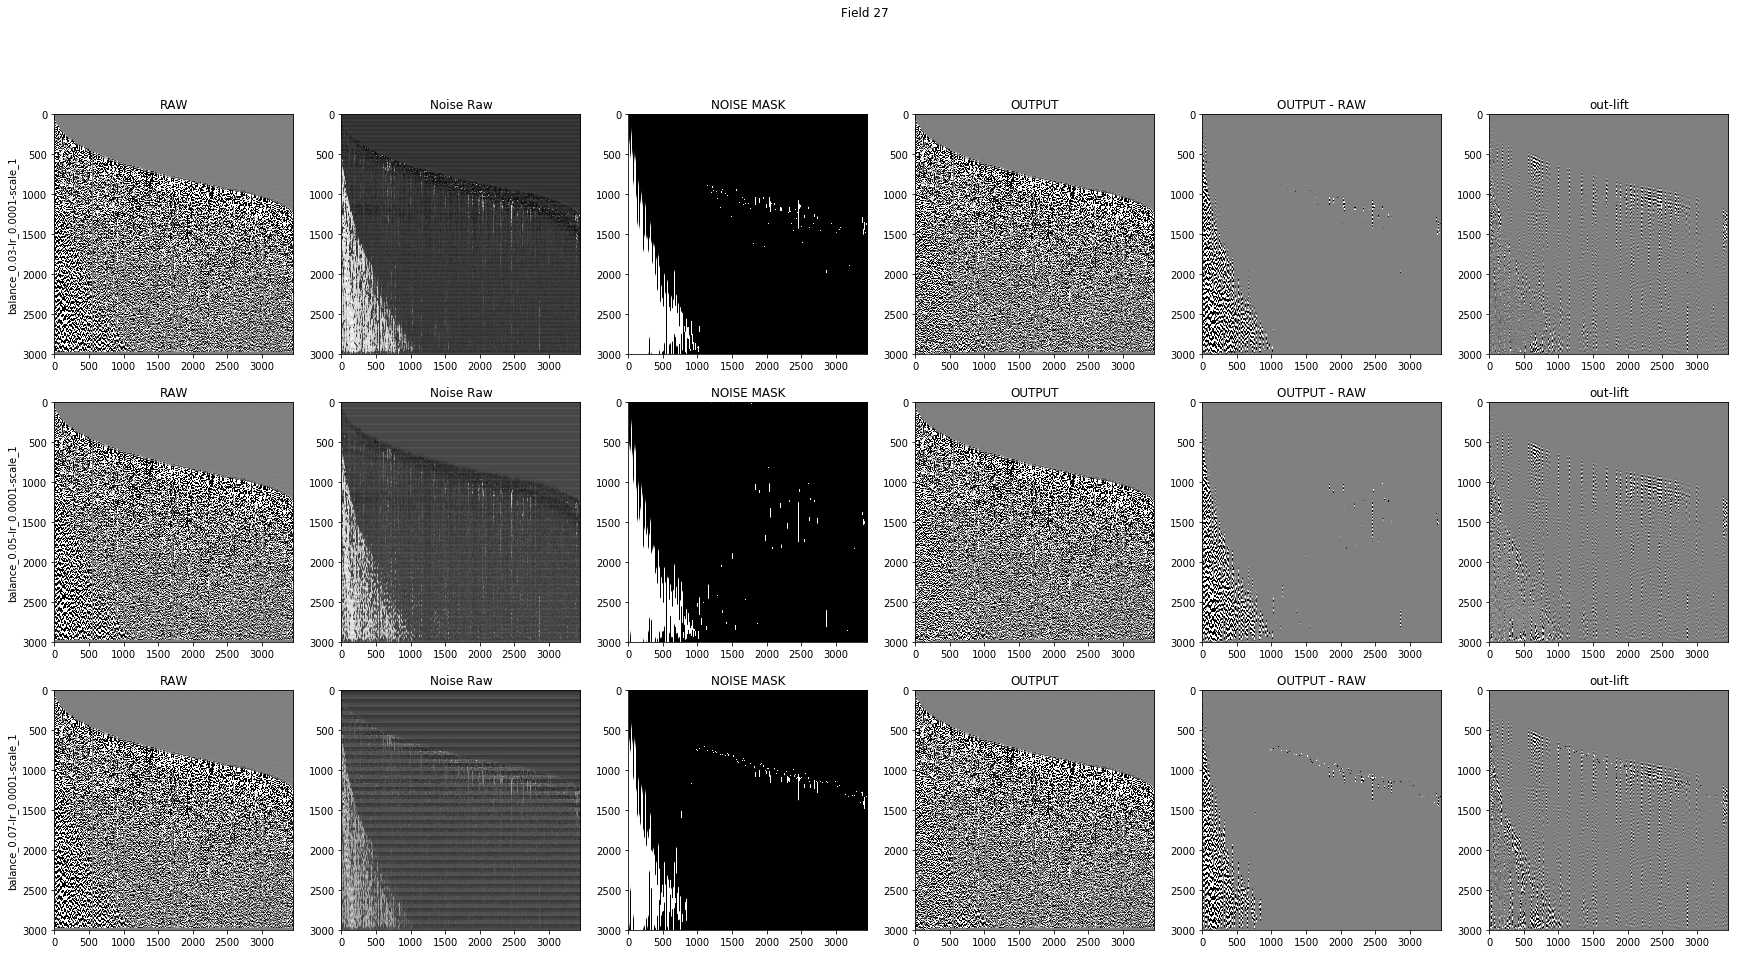

In [52]:
field_idx = 27
fig, ax = plt.subplots(3, 6, figsize=(30, 15), squeeze=False)
draw(field_idx, snapshots[snapshots.config.str.contains('scale_1')], arrs_maker, names, cvs, ax)




  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200





 50%|█████     | 1/2 [00:06<00:06,  6.31s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_19:30:45.220786+03:00/model-3200





100%|██████████| 2/2 [00:12<00:00,  6.35s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200





 50%|█████     | 1/2 [00:05<00:05,  5.91s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_20:17:22.496278+03:00/model-3200





100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200





 50%|█████     | 1/2 [00:06<00:06,  6.41s/it]

INFO:tensorflow:Restoring parameters from ./my_mdl/noise_dataset_1/2019-10-22_21:03:56.760339+03:00/model-3200





100%|██████████| 2/2 [00:11<00:00,  6.11s/it]

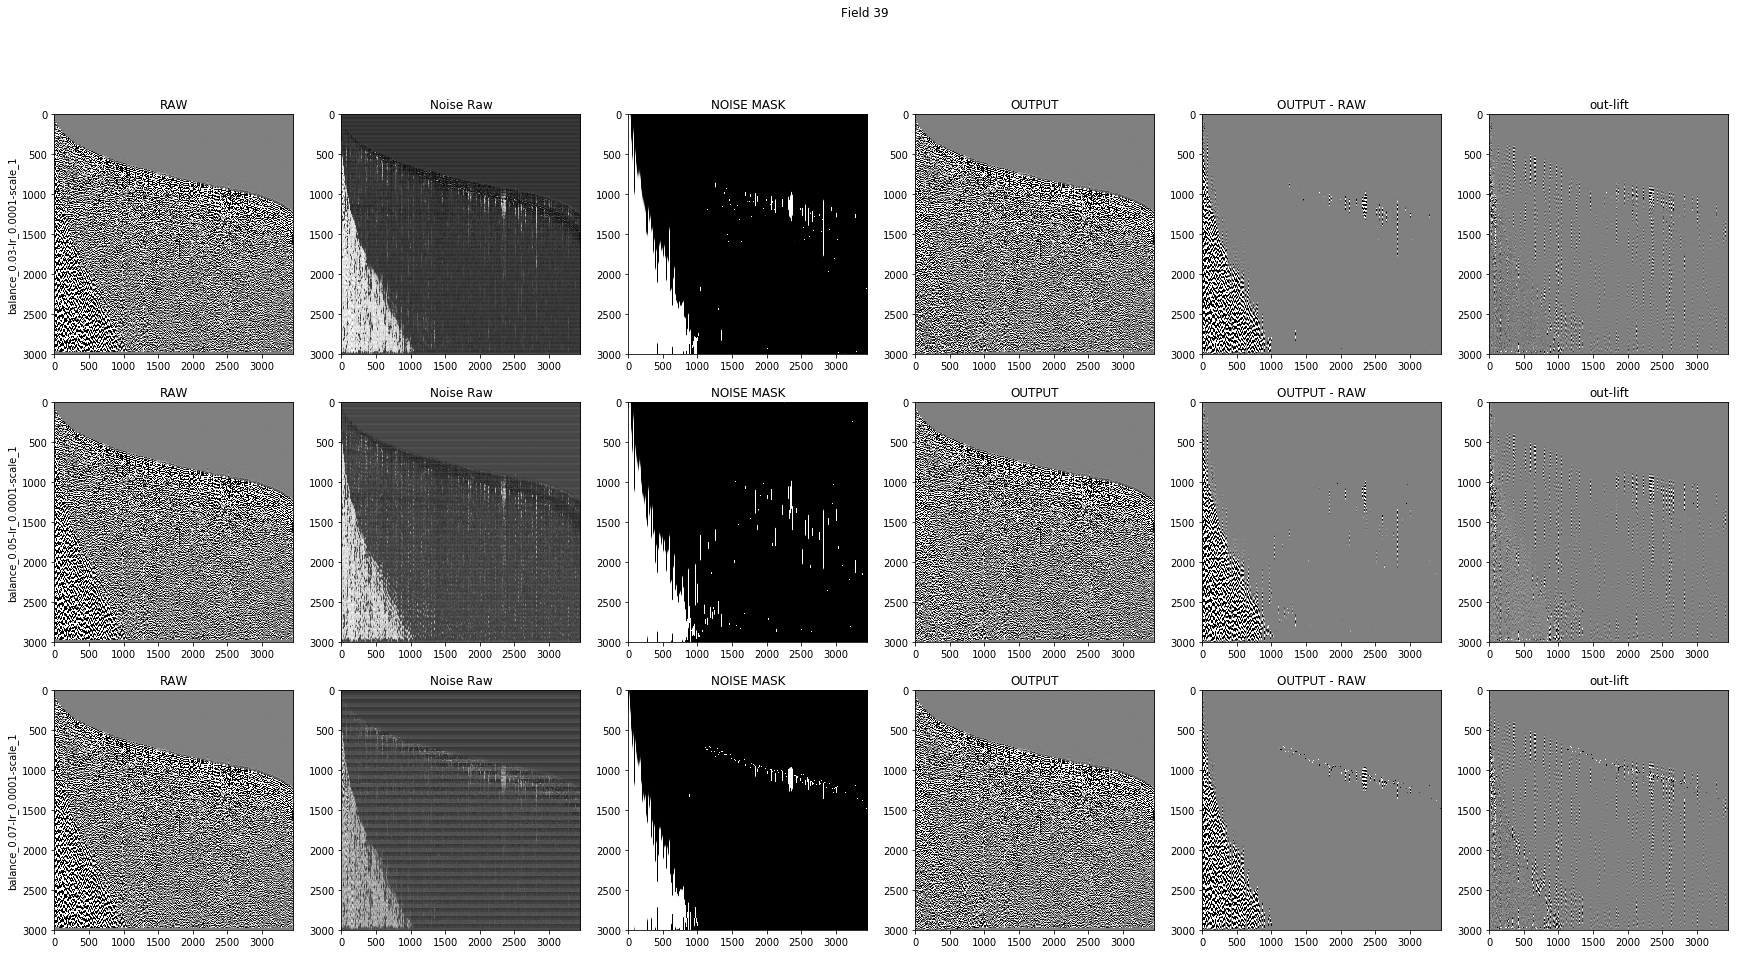

In [53]:
field_idx = 39
fig, ax = plt.subplots(3, 6, figsize=(30, 15), squeeze=False)
draw(field_idx, snapshots[snapshots.config.str.contains('scale_1')], arrs_maker, names, cvs, ax)

## LR = 0.0001 - or less
## scale = 1
## balance - not clear